# Welcome to ProgPy's LSTM Model Tutorial

In this example, we generate fake data using the ThrownObject model. This is a case where we're generating a surrogate model from the physics-based model. For cases where you're generating a model from data (e.g., collected from a testbed or a real-world environment), you'll replace that generated data with your own. We then use the generated model and compare to the original model.

Finally, we repeat the exercise with data from the more complex BatteryElectroChemEOD model.

Before we talk about what a LSTM is, we must first describe the data_model class!

The data_model class is an abstract base class for all Data Models (e.g., `LSTMStateTransitionModel`). The class defines the interface and all common tools! To create a new Data-Driven model, first subclass data_model, then define the abstract methods from this class and `prog_models.PrognosticsModel`. (To read more, consider viewing https://nasa.github.io/progpy/api_ref/prog_models/DataModel.html#prog_models.data_models.DataModel)

Within the data_model class, there are two functions that are worthwhile to look at.

#### from_data

The first is an abstract class method `from_data`. We can use `from_data` to create a Data Model from data. This class is overwritten by specific data-driven classes (e.g., `LSTMStateTransitionModel`). Furthermore, the method takes in a myriad of keyword arguments.

Keyword Arguments:
* __`times`__ __(list[list])__: list of input data for use in data. Each element is the times for a single run of size (n_times)
* __`inputs`__ __(list[np.array])__: list of :term:`input` data for use in data. Each element is the inputs for a single run of size (n_times, n_inputs)
* __`states`__ __(list[np.array])__: list of :term:`state` data for use in data. Each element is the states for a single run of size (n_times, n_states)
* __`outputs`__ __(list[np.array])__: list of :term:`output` data for use in data. Each element is the outputs for a single run of size (n_times, n_outputs)
* __`event_states`__ __(list[np.array])__: list of :term:`event state` data for use in data. Each element is the event states for a single run of size (n_times, n_event_states)
* __`time_of_event`__ __(np.array)__: Array of time of event data for use in data. Each element is the time of event for a single run of size (n_samples, n_events)
* __`input_keys`__ __(list[str])__: List of :term:`input` keys
* __`state_keys`__ __(list[str])__: List of :term:`state` keys
* __`output_keys`__ __(list[str])__: List of :term:`output` keys
* __`event_keys`__ __(list[str])__: List of :term:`event` keys


#### from_model

The second method is a class method `from_model`. We can use `from_model` to create a Data Model from an existing PrognosticsModel (i.e., a `surrogate` model). Generates data through simulation with supplied load functions. Then calls `from_data` to generate the model. The method has a few arguments a some keyword arguments as well.

Arguments:
* __`m`__ __(PrognosticsModel)__: Model to generate data from
* __`load_functions`__ __(list[function])__: Each index is a callable loading function of (t, x = None) -> z used to predict :term:`future load` at a given time (t) and :term:`state` (x)

Keyword Arguments:
* __`add_dt`__ __(bool)__: If the timestep should be added as an input

Returns:
* __`DataModel`__: Trained PrognosticsModel

Furthermore, `from_model` has additional configurations parameters from `prog_models.PrognosticsModel.simulate_to_threshold`. These can be an array (of same length as load_functions) of config for each individual sim, or one value to apply to all. Additional configuration parameters can also be found from `from_data`


______________________________________________________________________________________________________________________________________________________________________________________________________________

With our baseline understanding of `data_model`, we can now create the subclass `lstm_model`! 

The `lstm_model` is a State Transition Model with no `event` using an Keras LSTM Model. State transition models map from the `input` at time t and `output` at time t-1 plus historical data from a set window to the `output` at time t.

Most users will use the `LSTMStateTransitionModel.from_data` method to create a model, but the model can be created by passing in a model directly into the constructor. The LSTM model in this method maps from [u_t-n+1, z_t-n, ..., u_t, z_t-1] to z_t. Past `input` are stored in the `model` internal `state`. Actual calculation of `output` is performed when `LSTMStateTransitionModel.output` is called. When using in simulation that may not be until the simulation results are accessed.

Arguments:
* __`output_model`__ __(keras.Model)__: If a state model is present, maps from the state_model outputs to model :term:`output`. Otherwise, maps from model inputs to model :term:`output`
* __`state_model`__ __(keras.Model, optional)__: Keras model to use for state transition
* __`event_state_model`__ __(keras.Model, optional)__: If a state model is present, maps from the state_model outputs to :term:`event state`. Otherwise, maps from model inputs to :term:`event state`
* __`t_met_model`__ __(keras.Model, optional)__: If a state model is present, maps from the state_model outputs to if the threshold has been met. Otherwise, maps from model inputs to if the threshold has not been met

Keyword Arguments:
* __`input_keys`__ __(list[str])__: List of input keys
* __`output_keys`__ __(list[str])__: List of output keys
* __`event_keys`__ __(list[str])__: List of event keys

Attributes:
* __`model`__ __(keras.Model)__: Keras model to use for state transition

For more information on LSTM Models, please refer to our documentation at https://nasa.github.io/progpy/api_ref/prog_models/DataModel.html#prog_models.data_models.LSTMStateTransitionModel!

With our newfound knowledge, let's start with a basic example of using the lstm model!

We first must import the necessary modules.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from prog_models.data_models import LSTMStateTransitionModel
from prog_models.models import ThrownObject, BatteryElectroChemEOD

### Example 1) Set Timestep

For our first example, we will create a model for a specific timestep. The model will only work with that timestep. This is useful if you know the timestep you would like to use!

In [ ]:
TIMESTEP = 0.1

##### Step 1) Generate Data

For our first step, we'll use the ThrownObject model to generate data. For cases where you're generating a model from data (e.g., collected from a testbed or a real-world environment), you'll replace that generated data with your own.

In [ ]:
print('Generating data')
m = ThrownObject()

def future_loading(t, x=None):
    return m.InputContainer({})  # No input for thrown object 

data = m.simulate_to_threshold(future_loading, threshold_keys='impact', save_freq=TIMESTEP, dt=TIMESTEP)

##### Step 2) Generate Model

Next, we'll use the LSTMStateTransitionModel class to generate a model from the generated data!

Some information to note is that we are passing in the simulated data from the ThrownObject to our LSTM Model!

In [ ]:
print('Building model...')
m2 = LSTMStateTransitionModel.from_data(
    inputs=[data.inputs],
    outputs=[data.outputs],
    window=4,
    epochs=30,  # Maximum number of epochs, may stop earlier if early stopping enabled
    output_keys=['x'])

Note that we are using the `LSTMStateTransitionModel.from_data`. Remember that in `data_model`, `from_data()` was an abstract method. In other words, in our LSTM model, we must have redefined the `from_data` method! Let's take a look at how the method looks now:

Arguments:
* __`inputs`__ __(list[np.array])__: list of `input` data for use in data. Each element is the inputs for a single run of size (n_times, n_inputs)
* __`outputs`__ __(list[np.array])__: list of `output` data for use in data. Each element is the outputs for a single run of size (n_times, n_outputs)
* __`event_states`__ __(list[np.array], optional)__: list of `event state` data for use in data. Each element is the event state for a single run of size (n_times, n_events)
* __`t_met`__ __(list[np.array], optional)__: list of `threshold` met data for use in data. Each element is if the threshold has been met for a single run of size (n_times, n_events) 

Keyword Arguments:
* __`window`__ __(int)__: Number of historical points used in the model. I.e, if window is 3, the model will map from [t-3, t-2, t-1] to t
* __`input_keys`__ __(list[str])__: List of keys to use to identify :term:`input`. If not supplied u[#] will be used to identify inputs
* __`output_keys`__ __(list[str])__: List of keys to use to identify :term:`output`. If not supplied z[#] will be used to identify outputs
* __`event_keys`__ __(list[str])__: List of keys to use to identify events for :term:`event state` and :term:`threshold` met. If not supplied event[#] will be used to identify events
* __`validation_percentage`__ __(float)__: Percentage of data to use for validation, between 0-1
* __`epochs`__ __(int)__: Number of epochs (i.e., iterations) to train the model. More epochs means better results (to a point), but more time to train. Note: large numbers of epochs may result in overfitting
* __`layers`__ __(int)__: Number of LSTM layers to use. More layers can represent more complex systems, but are less efficient. Note: 2 layers is typically enough for most complex systems. Default: 1
* __`units`__ __(int or list[int])__: number of units (i.e., dimensionality of output state) used in each LSTM layer. Using a scalar value will use the same number of units for each layer
* __`activation`__ __(str or list[str])__: Activation function to use for each layer
* __`dropout`__ __(float)__: Dropout rate to be applied. Dropout helps avoid overfitting
* __`normalize`__ __(bool)__: If the data should be normalized. This is recommended for most cases
* __`early_stopping`__ __(bool)__: If early stopping is desired. Default is True
* __`early_stop.cfg`__ __(dict)__: Configuration to pass into early stopping callback (if enabled). See keras documentation (https://keras.io/api/callbacks/early_stopping) for options. E.g., {'patience': 5}
* __`workers`__ __(int)__: Number of workers to use when training. One worker indicates no multiprocessing

Returns:
* __`LSTMStateTransitionModel`__: Generated Model



Given the model that we created, we can see the training history! Intuitively, the history should show that the model is progressively getting better (i.e., loss goes down). If `val_loss` starts going up again, then we may be overtraining!

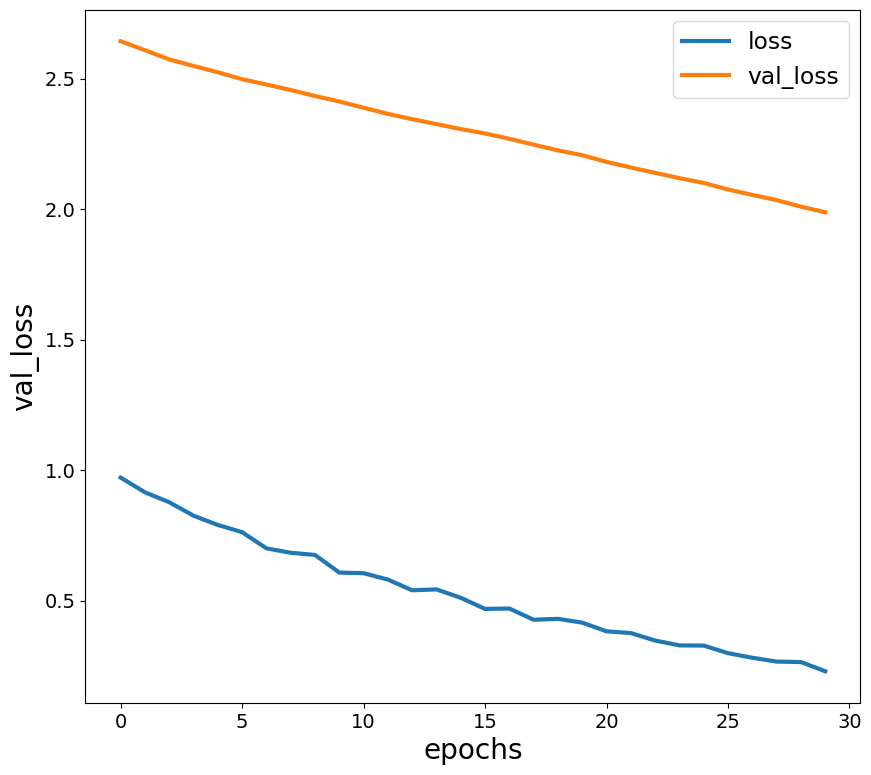

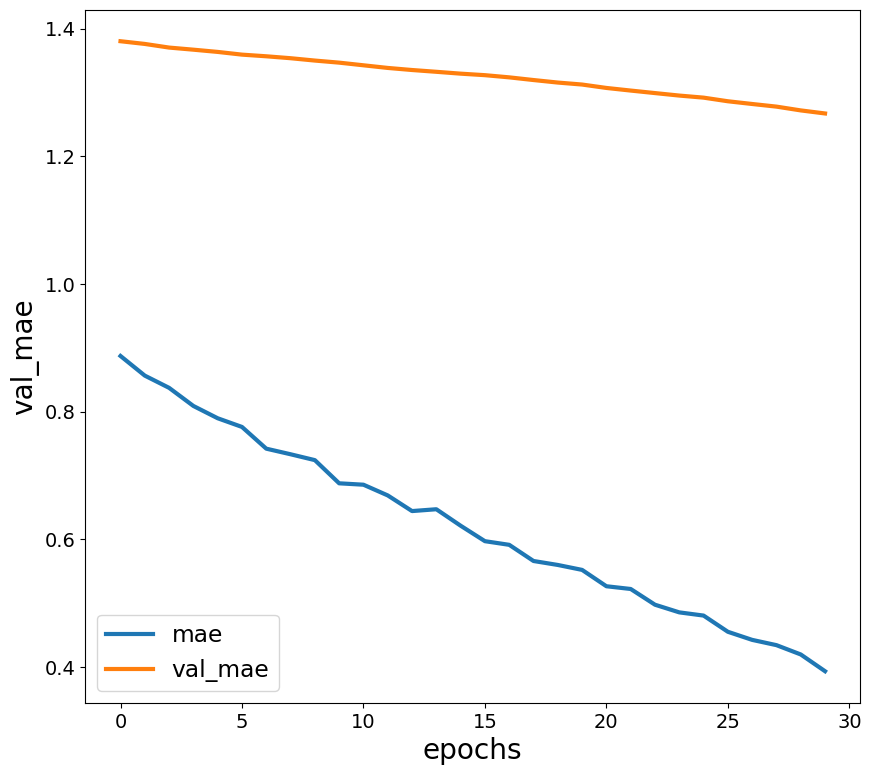

In [33]:
m2.plot_history()
plt.show()

##### Step 3: Use model to simulate_to time of threshold

In [ ]:
print('Simulating with generated model...')

t_counter = 0
x_counter = m.initialize()

def future_loading2(t, x=None):
    global t_counter, x_counter
    z = m.output(x_counter)
    z = m2.InputContainer(z.matrix)
    x_counter = m.next_state(x_counter, future_loading(t), t - t_counter)
    t_counter = t
    return z

results2 = m2.simulate_to(data.times[-1], future_loading2, dt=TIMESTEP, save_freq=TIMESTEP)

It is worth noting that our future loading function is a bit complicated here. Loading for the resulting model includes the data inputs, and the output from the last timestep.

##### Step 4: Compare model to original model

Comparing results...


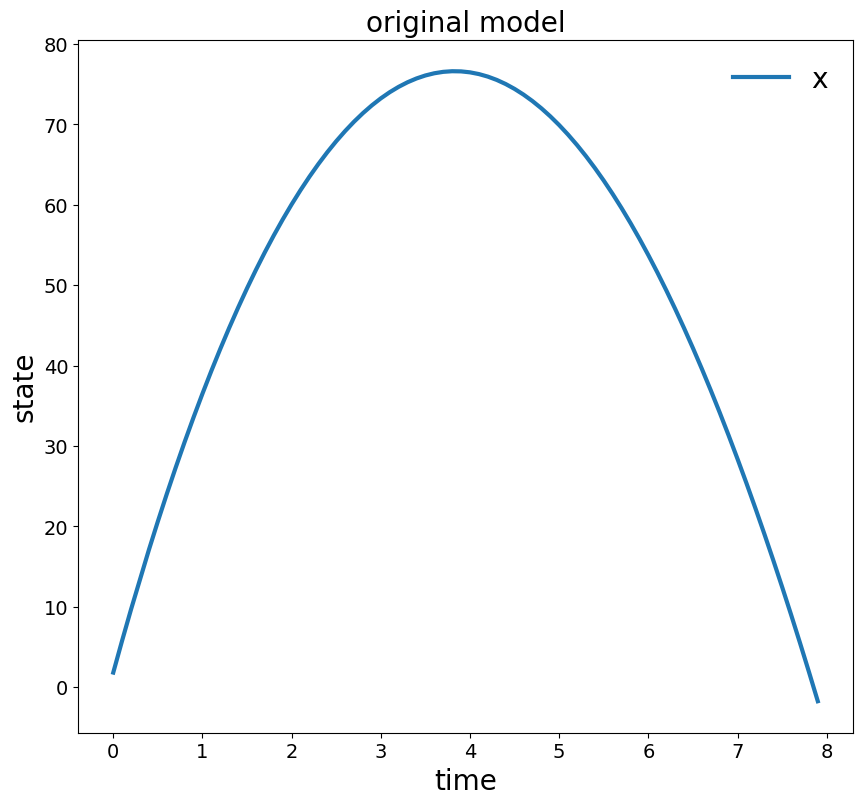

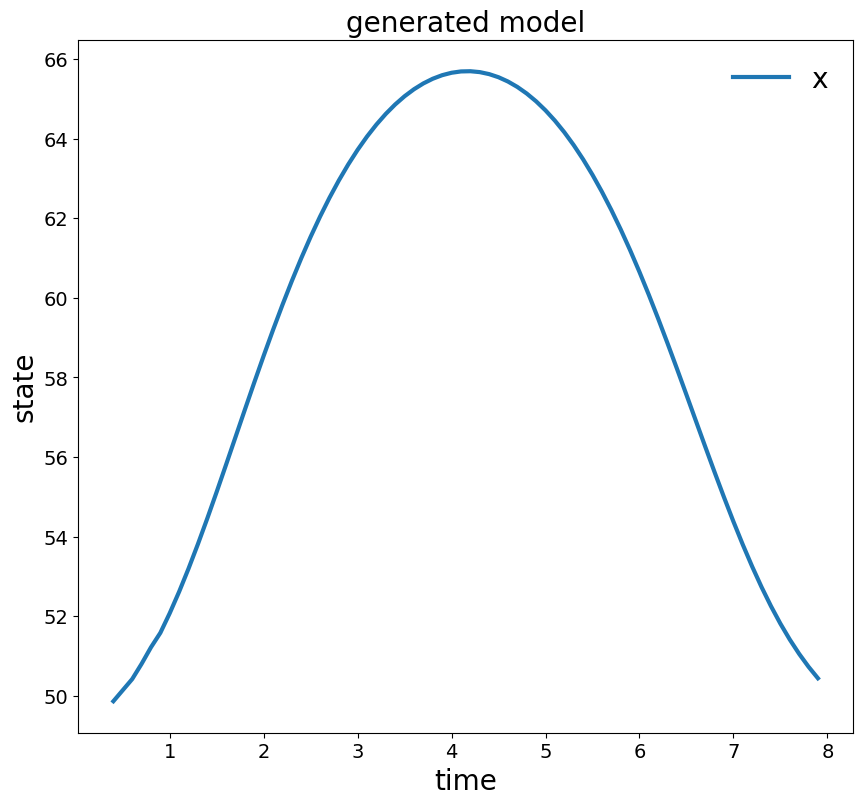

In [34]:
print('Comparing results...')
data.outputs.plot(title='original model')
results2.outputs.plot(title='generated model')
plt.show()

### Example 2) Variable Timestep

Now, we will create a model to work with any timestep! We do this by adding timestep as a variable in the model.

##### Step 1: Generate additional data

We will use data generated above, but we also want data at additional timesteps.

In [ ]:
print('\n------------------------------------------\nExample 2...')
print('Generating additional data...')
data_half = m.simulate_to_threshold(future_loading, threshold_keys='impact', save_freq=TIMESTEP/2, dt=TIMESTEP/2)
data_quarter = m.simulate_to_threshold(future_loading, threshold_keys='impact', save_freq=TIMESTEP/4, dt=TIMESTEP/4)
data_twice = m.simulate_to_threshold(future_loading, threshold_keys='impact', save_freq=TIMESTEP*2, dt=TIMESTEP*2)
data_four = m.simulate_to_threshold(future_loading, threshold_keys='impact', save_freq=TIMESTEP*4, dt=TIMESTEP*4)

##### Step 2: Data Prep

We need to add the timestep as a input!

In [ ]:
u = np.array([[TIMESTEP] for _ in data.inputs])
u_half = np.array([[TIMESTEP/2] for _ in data_half.inputs])
u_quarter = np.array([[TIMESTEP/4] for _ in data_quarter.inputs])
u_twice = np.array([[TIMESTEP*2] for _ in data_twice.inputs])
u_four = np.array([[TIMESTEP*4] for _ in data_four.inputs])

input_data = [u, u_half, u_quarter, u_twice, u_four]
output_data = [data.outputs, data_half.outputs, data_quarter.outputs, data_twice.outputs, data_four.outputs]

##### Step 3: Generate Model

In [ ]:
print('Building model...')
m3 = LSTMStateTransitionModel.from_data(
    inputs=input_data,
    outputs=output_data,
    window=4,
    epochs=30,
    input_keys=['dt'],
    output_keys=['x'])

__NOTE__: Since we're generating from a model, we could also have done this:

In [ ]:
EXAMPLE_MODEL = LSTMStateTransitionModel.from_model(
    m,
    [future_loading for _ in range(5)],
    dt = [TIMESTEP, TIMESTEP/2, TIMESTEP/4, TIMESTEP*2, TIMESTEP*4],
    window=4,
    epochs=30)

Notice that we are passing in `input_data` and `output_data` that is made up of multiple Timesteps.

Let's take a look at the training history!

In [ ]:
m3.plot_history()
plt.show()

Similarly to the previous example, the more we train, the lower our loss!

##### Step 4: Simulate with model

In [ ]:
t_counter = 0
x_counter = m.initialize()

def future_loading3(t, x=None):
    global t_counter, x_counter
    z = m3.InputContainer({'x_t-1': x_counter['x'], 'dt': t - t_counter})
    x_counter = m.next_state(x_counter, future_loading(t), t - t_counter)
    t_counter = t
    return z

data = m.simulate_to(data.times[-1], future_loading, dt=TIMESTEP*3, save_freq=TIMESTEP*3)
results3 = m3.simulate_to(data.times[-1], future_loading3, dt=TIMESTEP*3, save_freq=TIMESTEP*3)

We are using the new dt, not used in the training. by using a dt not used in the training, this will demonstrate the mode's ability to handle different timesteps not part of the the training set!

##### Step 5: Compare Results

In [ ]:
print('Comparing results...')
data.outputs.plot(title='original model')
results3.outputs.plot(title='generated model')
plt.show()